In [14]:
%reset

In [15]:
#import packages 

import rasterio

import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.io.shapereader import Reader
#from cartopy.feature import ShapelyFeature  
#from matplotlib import pyplot
#import rasterstats
#import regionmask
import xarray as xr
#import xesmf as xe
import numpy as np
import pandas as pd
from datetime import datetime
import rioxarray
import pymannkendall as mk
import seaborn as sns
import numpy as np
import scipy as sp
from sklearn.metrics import r2_score

In [16]:
from matplotlib import gridspec
import os
ROOT_DIR = os.path.abspath(os.curdir)

In [17]:
def calc_water_year(date):
    date = pd.to_datetime(date)
    if 10 <= date.month <= 12:
        water_year = date.year + 1
        return water_year
    else:
        return date.year

In [18]:
def calc_water_year_apply(df):
    df['water_year'] = df.datetime.apply(lambda row: calc_water_year(row))

In [19]:
#load and plot SNOTEL data 

path_Skookum = ROOT_DIR + '/Data/Raw/bcqc_47.68000_-121.61000._Skookum_Creek.txt'
path_Alpine = ROOT_DIR + '/Data/Raw/bcqc_47.78000_-121.70000_Alpine_Meadows.txt'

path_Skook_model_1deg = ROOT_DIR + '/Data/Raw/comparison_Pixel.Skookum_Creek_prism_delta_05_1deg.csv'
path_Skook_model_2deg = ROOT_DIR + '/Data/Raw/comparison_Pixel.Skookum_Creek_prism_delta_05_2deg.csv'
path_Skook_model_3deg = ROOT_DIR + '/Data/Raw/comparison_Pixel.Skookum_Creek_prism_delta_05_3deg.csv'
path_Skook_model_4deg = ROOT_DIR + '/Data/Raw/comparison_Pixel.Skookum_Creek_prism_delta_05_4deg.csv'


def snotel_data(path_snotel):
    snotel_obs = pd.read_csv(path_snotel, sep='\s+', header=None)
    snotel_obs.columns = ['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F','SWE_in'] 
    snotel_obs['Tmean_C'] = (snotel_obs['Tmean_F'] - 32) * (5/9)
    snotel_obs = snotel_obs.set_index(pd.DatetimeIndex(pd.to_datetime(snotel_obs[['year', 'month', 'day']])))
    snotel_obs['SWE_m'] = snotel_obs['SWE_in']*0.0254
    snotel_obs['datetime'] = snotel_obs.index
    calc_water_year_apply(snotel_obs)
    return snotel_obs

In [20]:
#create dataframes for SNOTEL stations 
snotel_Skookum = snotel_data(path_Skookum)
snotel_Alpine = snotel_data(path_Alpine)


/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_75323/2597685747.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


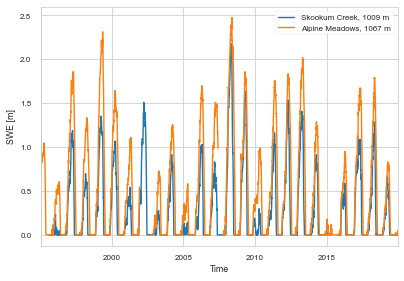

In [21]:
#plot SNOTELS:
plt.style.use('seaborn-paper')
ax = snotel_Skookum.plot(kind='line',  y = 'SWE_m', label = 'Skookum Creek, 1009 m')
snotel_Alpine.plot(kind='line', y = 'SWE_m', label = 'Alpine Meadows, 1067 m', ax = ax)
ax.set_xlim([datetime(1995, 1, 21), datetime(2019, 12, 1)])
plt.xlabel('Time')
plt.ylabel('SWE [m]')

plt.show()

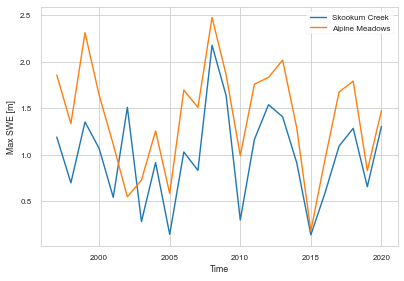

In [22]:
Alpine_max_SWE = snotel_Alpine.loc['1996-10-1':'2020-09-30'].groupby('water_year')['SWE_m'].max()
Skook_max_SWE = snotel_Skookum.loc['1996-10-1':'2020-09-30'].groupby('water_year')['SWE_m'].max()

ax = Skook_max_SWE.plot(kind='line',  y = 'SWE_m', label = 'Skookum Creek, zzz m')
Alpine_max_SWE.plot(kind='line', y = 'SWE_m', label = 'Alpine Meadows, zz m', ax = ax)

#ax.set_xlim([datetime(1995, 1, 21), datetime(2019, 12, 1)])
plt.xlabel('Time')
plt.ylabel('Max SWE [m]')

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Skookum Creek", "Alpine Meadows"], loc = 0, frameon = legend_drawn_flag)

plt.show()



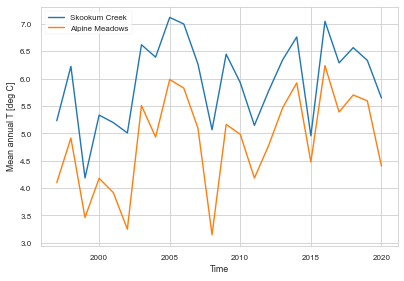

In [23]:
Alpine_T = snotel_Alpine.loc['1996-10-1':'2020-09-30'].groupby('water_year')['Tmean_C'].mean()
Skook_T = snotel_Skookum.loc['1996-10-1':'2020-09-30'].groupby('water_year')['Tmean_C'].mean()

ax = Skook_T.plot(kind='line', label = 'Skookum Creek, zzz m')
Alpine_T.plot(kind='line', label = 'Alpine Meadows, zz m', ax = ax)


#ax.set_xlim([datetime(1995, 1, 21), datetime(2019, 12, 1)])
plt.xlabel('Time')
plt.ylabel('Mean annual T [deg C]')

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Skookum Creek", "Alpine Meadows"], loc = 0, frameon = legend_drawn_flag)

plt.show()

#daily_P_in.fillna(0)

In [24]:
#plot max SWE = fcn(T) with Matplotlb
#fig, (ax1, ax2) = plt.subplots(2, 1, sharey = True)
#ax1.scatter(Skook_T.values, Skook_max_SWE.values)
#ax2.scatter(Alpine_T.values, Alpine_max_SWE)

Text(0, 0.5, 'Max SWE [m]')

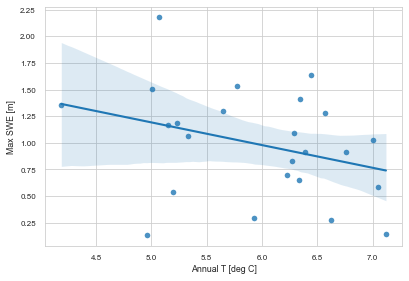

In [25]:
#import seaborn as sns #sns.set_theme(color_codes=True)
#fig, (ax11, ax12) = plt.subplots(1, 1, sharey = True)
ax11 = sns.regplot(x = Skook_T.values, y = Skook_max_SWE.values)
#ax1.set_title('Sharing Y axis')
#ax12 = sns.regplot(x = Alpine_T.values, y = Alpine_max_SWE)
#ax = sns.regplot(x=x, y=y, color="g")
location = 0 # For the best location
legend_drawn_flag = True
#plt.legend(["Skookum Creek", "Alpine Meadows"], loc = 0, frameon = legend_drawn_flag)
plt.xlabel('Annual T [deg C]')
plt.ylabel('Max SWE [m]')

In [26]:
#data framea as xarray datasets
skook_ds = snotel_Skookum.to_xarray()
alpine_ds = snotel_Alpine.to_xarray()

In [27]:
def seasonal_mean(**query):
    ds_by_season = query['dataset'].sel(index = query['time'])[query['variable']].resample(index="QS-DEC").mean('index')
    if query['season'] == 'DJF':
        se_select = ds_by_season['index'].dt.month==12
        data_select = ds_by_season.isel(index = se_select)
    elif query['season'] == 'MAM':
        se_select = ds_by_season['index'].dt.month==3
        data_select = ds_by_season.isel(index = se_select)
    elif query['season'] == 'JJA':
        se_select = ds_by_season['index'].dt.month==6
        data_select = ds_by_season.isel(index = se_select)
    elif query['season'] == 'SON':
        se_select = ds_by_season['index'].dt.month==9
        data_select = ds_by_season.isel(index = se_select)
    else:
        print('Select season')
    return data_select

In [28]:
qu_Skook = {
    'dataset': skook_ds,
    'time': slice('1996-10-1','2020-09-30'),
    'season': 'DJF',
    'variable': 'Tmean_C'
}

qu_Alpine = {
    'dataset': skook_ds,
    'time': slice('1996-10-1','2020-09-30'),
    'season': 'DJF',
    'variable': 'Tmean_C'
}

DJF_temp_Skook = seasonal_mean(**qu_Skook)
DJF_temp_Alpine = seasonal_mean(**qu_Alpine)

-0.7782787195515228

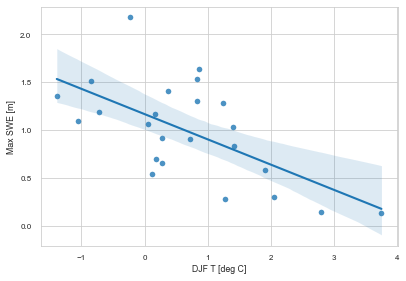

In [29]:
#import seaborn as sns #sns.set_theme(color_codes=True)
#fig, (ax11, ax12) = plt.subplots(1, 1, sharey = True)
ax11 = sns.regplot(x = DJF_temp_Skook, y = Skook_max_SWE.values)
#ax1.set_title('Sharing Y axis')
#ax12 = sns.regplot(x = DJF_temp_Alpine, y = Alpine_max_SWE)
#ax = sns.regplot(x=x, y=y, color="g")
location = 0 # For the best location
legend_drawn_flag = True
#plt.legend(["Skookum Creek", "Alpine Meadows"], loc = 0, frameon = legend_drawn_flag)
r, p = sp.stats.pearsonr(DJF_temp_Skook, Skook_max_SWE.values)
ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
        transform=ax.transAxes)
plt.xlabel('DJF T [deg C]')
plt.ylabel('Max SWE [m]')
r2 = r2_score(DJF_temp_Skook, Skook_max_SWE.values)
r2

In [30]:
DJF_temp_Skook

<xarray.DataArray 'Tmean_C' (index: 24)>
array([-0.71354557,  0.1808642 , -1.3895679 ,  0.05579976,  0.11728395,
       -0.8491358 ,  1.27444444,  0.28259259,  2.80037037,  1.39539141,
        1.42067901, -0.23133583,  0.86117284,  2.04564394,  0.15991162,
        0.83639847,  0.36524691,  0.71493827,  3.75012771,  1.91080586,
       -1.05259259,  1.23933081,  0.26987654,  0.82295482])
Coordinates:
  * index    (index) datetime64[ns] 1996-12-01 1997-12-01 ... 2019-12-01

In [40]:
DJF_temp_Skook

<xarray.DataArray 'Tmean_C' (index: 24)>
array([-0.71354557,  0.1808642 , -1.3895679 ,  0.05579976,  0.11728395,
       -0.8491358 ,  1.27444444,  0.28259259,  2.80037037,  1.39539141,
        1.42067901, -0.23133583,  0.86117284,  2.04564394,  0.15991162,
        0.83639847,  0.36524691,  0.71493827,  3.75012771,  1.91080586,
       -1.05259259,  1.23933081,  0.26987654,  0.82295482])
Coordinates:
  * index    (index) datetime64[ns] 1996-12-01 1997-12-01 ... 2019-12-01

In [17]:
 Skook_max_SWE.values

array([1.18872, 0.69596, 1.35128, 1.0668 , 0.54102, 1.50876, 0.2794 ,
       0.9144 , 0.14224, 1.0287 , 0.83058, 2.17678, 1.63322, 0.29718,
       1.16332, 1.5367 , 1.40716, 0.91186, 0.13716, 0.58674, 1.0922 ,
       1.2827 , 0.65532, 1.30302])

In [18]:
def seasonal_accum(**query):
    ds_by_season = query['dataset'].sel(index = query['time'])[query['variable']].resample(index="QS-DEC").sum('index')
    if query['season'] == 'DJF':
        se_select = ds_by_season['index'].dt.month==12
        data_select = ds_by_season.isel(index = se_select)
    elif query['season'] == 'MAM':
        se_select = ds_by_season['index'].dt.month==3
        data_select = ds_by_season.isel(index = se_select)
    elif query['season'] == 'JJA':
        se_select = ds_by_season['index'].dt.month==6
        data_select = ds_by_season.isel(index = se_select)
    elif query['season'] == 'SON':
        se_select = ds_by_season['index'].dt.month==9
        data_select = ds_by_season.isel(index = se_select)
    else:
        print('Select season')
    return data_select

In [19]:
qu_Skook_DJF_p = {
    'dataset': skook_ds,
    'time': slice('1996-10-1','2020-09-30'),
    'season': 'DJF',
    'variable': 'daily_P_in'
}

MAM_p_Skook = seasonal_accum(**qu_Skook_DJF_p)
MAM_p_Skook.values

array([70.3, 45.5, 78.5, 62.7, 31. , 65.9, 44. , 51.8, 41.6, 60.6, 52. ,
       71. , 30.8, 29.9, 74.7, 62.7, 63.9, 59.9, 55. , 73. , 50.5, 77.7,
       48.4, 98.1])

In [20]:
skook_ds

<xarray.Dataset>
Dimensions:     (index: 9529)
Coordinates:
  * index       (index) datetime64[ns] 1995-08-30 1995-08-31 ... 2021-09-30
Data variables:
    year        (index) int64 1995 1995 1995 1995 1995 ... 2021 2021 2021 2021
    month       (index) int64 8 8 9 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9 9 9
    day         (index) int64 30 31 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29 30
    daily_P_in  (index) float64 nan nan nan nan nan nan ... 0.3 1.5 1.9 0.0 1.6
    Tmax_F      (index) float64 65.4 72.61 78.79 82.91 ... 43.77 50.98 52.01
    Tmin_F      (index) float64 48.92 48.92 58.19 58.19 ... 39.65 38.62 40.68
    Tmean_F     (index) float64 53.04 61.28 67.46 68.49 ... 41.71 44.8 46.86
    SWE_in      (index) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.1 0.2 0.2 0.2 0.2
    Tmean_C     (index) float64 11.69 16.27 19.7 20.27 ... 5.394 7.111 8.256
    SWE_m       (index) float64 0.0 0.0 0.0 0.0 ... 0.00508 0.00508 0.00508
    datetime    (index) datetime64[ns] 1995-08-30 1995-08-31 ... 2021-09-30
    water_year  (index) int64 1995 1995 1995 1995 1995 ... 2021 2021 2021 2021

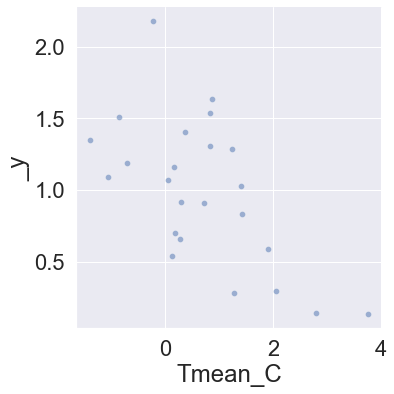

In [21]:
sns.set(font_scale=2)
sns.relplot(x = DJF_temp_Skook, y = Skook_max_SWE.values,
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6)

In [22]:
DJF_temp_Skook


<xarray.DataArray 'Tmean_C' (index: 24)>
array([-0.71354557,  0.1808642 , -1.3895679 ,  0.05579976,  0.11728395,
       -0.8491358 ,  1.27444444,  0.28259259,  2.80037037,  1.39539141,
        1.42067901, -0.23133583,  0.86117284,  2.04564394,  0.15991162,
        0.83639847,  0.36524691,  0.71493827,  3.75012771,  1.91080586,
       -1.05259259,  1.23933081,  0.26987654,  0.82295482])
Coordinates:
  * index    (index) datetime64[ns] 1996-12-01 1997-12-01 ... 2019-12-01

In [23]:

g = sns.lmplot(x = DJF_temp_Skook, y = Skook_max_SWE.values)

def annotate():
    r, p = sp.stats.pearsonr(DJF_temp_Skook, Skook_max_SWE.values)
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

g.map_dataframe(annotate)
plt.show()


TypeError: Missing required keyword argument `data`.

In [24]:
 r, p = sp.stats.pearsonr(DJF_temp_Skook, Skook_max_SWE.values)
r
p

0.0012295382836647003

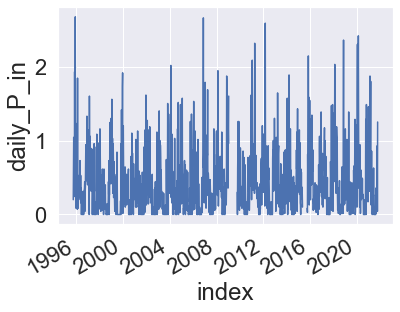

In [25]:
test = skook_ds['daily_P_in'].resample(index = "1w").mean(dim = "index")
test.plot()

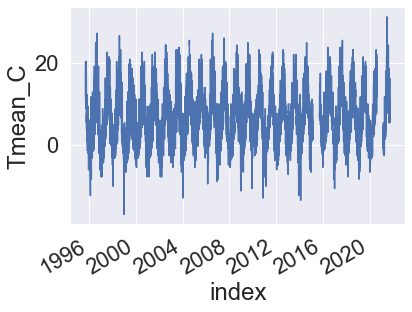

In [26]:
test = skook_ds['Tmean_C'].plot()

In [27]:
# calculate monthly climatology
#climatology = skook_ds.groupby('month').mean()
Skook_monthly_pre = skook_ds.sel(index = slice('1996-10-1','2008-09-30')).groupby('month').mean()
Skook_monthly_post = skook_ds.sel(index = slice('2008-09-30','2020-09-30')).groupby('month').mean()

Alpine_monthly_pre = alpine_ds.sel(index = slice('1996-10-1','2008-09-30')).groupby('month').mean()
Alpine_monthly_post = alpine_ds.sel(index = slice('2008-09-30','2020-09-30')).groupby('month').mean()


In [28]:
Alpine_monthly_post

<xarray.Dataset>
Dimensions:     (month: 12)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    year        (month) float64 2.014e+03 2.015e+03 ... 2.014e+03 2.014e+03
    day         (month) float64 16.0 14.63 16.0 15.5 ... 15.54 16.0 15.5 16.0
    daily_P_in  (month) float64 0.8293 0.71 0.7465 ... 0.5704 0.7717 0.7086
    Tmax_F      (month) float64 37.88 36.41 39.77 44.39 ... 49.01 40.35 34.49
    Tmin_F      (month) float64 30.5 27.78 29.68 32.65 ... 39.06 32.74 27.59
    Tmean_F     (month) float64 33.84 31.39 33.69 37.13 ... 43.16 36.15 30.73
    SWE_in      (month) float64 20.47 28.73 41.13 50.48 ... 0.157 2.371 9.515
    Tmean_C     (month) float64 1.024 -0.3364 0.9395 2.85 ... 6.2 2.308 -0.7039
    SWE_m       (month) float64 0.5199 0.7296 1.045 ... 0.003988 0.06022 0.2417
    water_year  (month) float64 2.014e+03 2.015e+03 ... 2.014e+03 2.014e+03

Text(0, 0.5, 'Monthly P [in]')

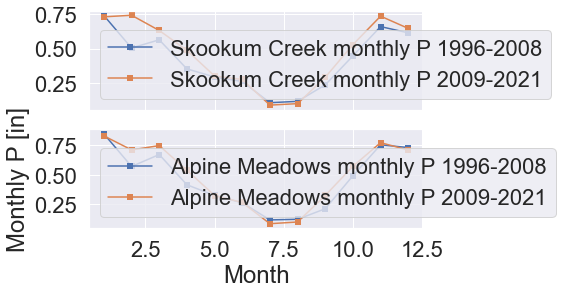

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)

Skook_monthly_pre['daily_P_in'].to_dataframe().plot(style="s-", ax = ax1)
Skook_monthly_post['daily_P_in'].to_dataframe().plot(style="s-", ax = ax1)

location = 0 # For the best location
legend_drawn_flag = True
ax1.legend(["Skookum Creek monthly P 1996-2008", "Skookum Creek monthly P 2009-2021"], loc = 0, frameon = legend_drawn_flag)
#plt.xlabel('Month')
plt.ylabel('Monthly P [in]')

Alpine_monthly_pre['daily_P_in'].to_dataframe().plot(style="s-", ax = ax2)
Alpine_monthly_post['daily_P_in'].to_dataframe().plot(style="s-", ax = ax2)

location = 0 # For the best location
legend_drawn_flag = True
ax2.legend(["Alpine Meadows monthly P 1996-2008", "Alpine Meadows monthly P 2009-2021"], loc = 0, frameon = legend_drawn_flag)
plt.xlabel('Month')
plt.ylabel('Monthly P [in]')


Text(0, 0.5, 'Monthly SWE [m]')

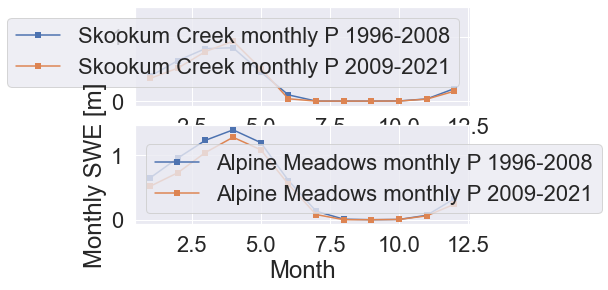

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharey = True)


Skook_monthly_pre['SWE_m'].to_dataframe().plot(style="s-", ax = ax1)
Skook_monthly_post['SWE_m'].to_dataframe().plot(style="s-", ax = ax1)
plt.ylabel('Monthly SWE [m]')
location = 0 # For the best location
legend_drawn_flag = True
ax1.legend(["Skookum Creek monthly P 1996-2008", "Skookum Creek monthly P 2009-2021"], loc = 0, frameon = legend_drawn_flag)
#plt.xlabel('Month')


Alpine_monthly_pre['SWE_m'].to_dataframe().plot(style="s-", ax = ax2)
Alpine_monthly_post['SWE_m'].to_dataframe().plot(style="s-", ax = ax2)
location = 0 # For the best location
legend_drawn_flag = True
ax2.legend(["Alpine Meadows monthly P 1996-2008", "Alpine Meadows monthly P 2009-2021"], loc = 0, frameon = legend_drawn_flag)
plt.xlabel('Month')
plt.ylabel('Monthly SWE [m]')

Text(0, 0.5, 'Monthly T [degC]')

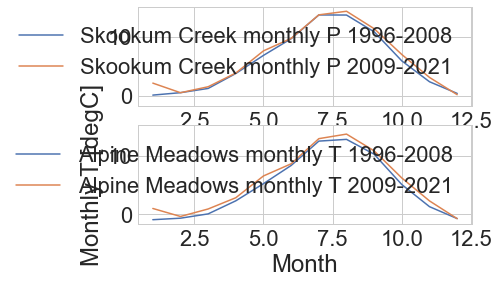

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharey = True)

Skook_monthly_pre['Tmean_C'].to_dataframe().plot(style="s-", ax = ax1)
Skook_monthly_post['Tmean_C'].to_dataframe().plot(style="s-", ax = ax1)
plt.ylabel('Monthly T [degC]')
location = 0 # For the best location
legend_drawn_flag = True
#plt.style.use('seaborn-whitegrid')
ax1.legend(["Skookum Creek monthly P 1996-2008", "Skookum Creek monthly P 2009-2021"])#, loc = 0, frameon = legend_drawn_flag)
#plt.xlabel('Month')


Alpine_monthly_pre['Tmean_C'].to_dataframe().plot(style="s-", ax = ax2)
Alpine_monthly_post['Tmean_C'].to_dataframe().plot(style="s-", ax = ax2)
location = 0 # For the best location
legend_drawn_flag = True
#plt.style.use('seaborn-whitegrid')
ax2.legend(["Alpine Meadows monthly T 1996-2008", "Alpine Meadows monthly T 2009-2021"])#, loc = 0, frameon = legend_drawn_flag)
plt.xlabel('Month')
plt.ylabel('Monthly T [degC]')

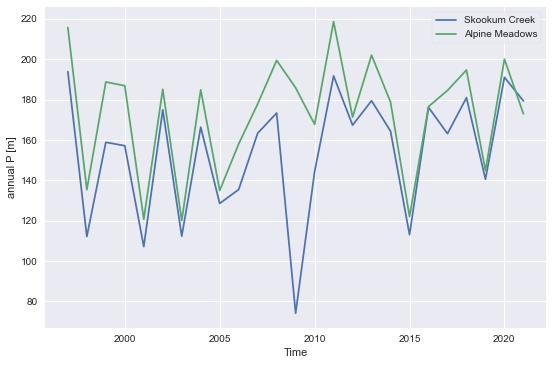

In [160]:
Alpine_P = snotel_Alpine.loc['1996-10-1':'2021-09-30'].groupby('water_year')['daily_P_in'].sum()
Skook_P = snotel_Skookum.loc['1996-10-1':'2021-09-30'].groupby('water_year')['daily_P_in'].sum()

ax = Skook_P.plot(kind='line', label = 'Skookum Creek, zzz m')
Alpine_P.plot(kind='line', label = 'Alpine Meadows, zz m', ax = ax)
plt.style.use('seaborn-v0_8')


#ax.set_xlim([datetime(1995, 1, 21), datetime(2019, 12, 1)])
plt.xlabel('Time')
plt.ylabel('annual P [m]')

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Skookum Creek", "Alpine Meadows"], loc=0, frameon=legend_drawn_flag)

plt.show()


In [161]:
#trend test, Mann-Kendall
mk.original_test(Skook_max_SWE.values)

Mann_Kendall_Test(trend='no trend', h=False, p=0.9802109790485438, z=0.024804403006957923, Tau=0.007246376811594203, s=2.0, var_s=1625.3333333333333, slope=0.0020170588235294117, intercept=1.0245538235294118)

In [34]:
def plotSWE_P_T(t, sP, sSWE, sT, time_period):
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
    
    # SWE plot
    ax = plt.subplot(gs[1])
    ax.plot(t, sSWE, color = 'red')
    # Create secondary axes
    ax2 = ax.twinx()
    c = 'orange'
    ax2.bar(t, -sP, color = c)

    # Now need to fix the axis labels
    max_pre = max(sP)
    y2_ticks = np.linspace(0, int(max_pre), int(max_pre + 1))
    #y2_ticks = np.int(y2_ticks)

    y2_ticklabels = [str(i) for i in y2_ticks]
    ax2.set_yticks(-1 * y2_ticks)
    ax2.set_yticklabels(y2_ticklabels)

    ax.set_xlim(time_period) 
    
    ax.set_ylabel('SWE[unit]', color='k')
    ax2.set_ylabel('P[unit]', color='k')
    ax.set_xlabel('Time [day]')
                  
    ax.tick_params(axis='y', colors='k')
    ax.xaxis.grid(visible = None, which='major', color ='.7', linestyle='-')
    ax.yaxis.grid(visible = None, which='major', color ='.7', linestyle='-')
    ax.set_xlim(min(t), max(t))
    ax.set_ylim(0, np.nanmax(sSWE)*1.2)
    ax.set_xlim(time_period)
    ax.tick_params(axis='x', labelrotation = 45)
    # temperature plot
    ax2 = plt.subplot(gs[0])
    
    ax2.plot(t, sT) 
    ax2.xaxis.grid(visible = None, which='major', color='.7', linestyle='-')
    ax2.yaxis.grid(visible = None, which='major', color='0.7', linestyle='-')
    ax2.set_ylabel('T(deg C)')
    ax2.set_xlim(min(t), max(t))
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    plt.tight_layout()
    #ax2.invert_yaxis()
    plt.gcf().subplots_adjust(bottom=0.15)
    ax2.set_xlim(time_period)
    #ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
    plt.style.use('seaborn-whitegrid')
    plt.show()
    #plt.savefig(filename,format='pdf')
    plt.close(fig)

In [164]:
import plotting as pt

ModuleNotFoundError: No module named 'plotting'

/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_29596/1207554259.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


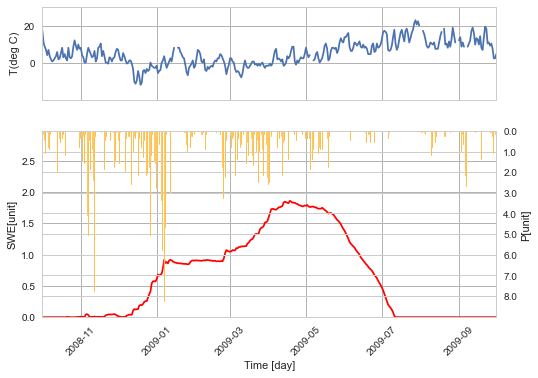

In [166]:

t = snotel_Alpine.index
sP = snotel_Alpine.daily_P_in.fillna(0)
sSWE = snotel_Alpine.SWE_m
sT = snotel_Alpine.Tmean_C
time_period = [datetime(2008, 10, 1), datetime(2009, 10, 1)] 

plotSWE_P_T(snotel_Alpine.index,
            snotel_Alpine.daily_P_in.fillna(0), 
            snotel_Alpine.SWE_m, snotel_Alpine.Tmean_C, time_period)

/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_29596/1207554259.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


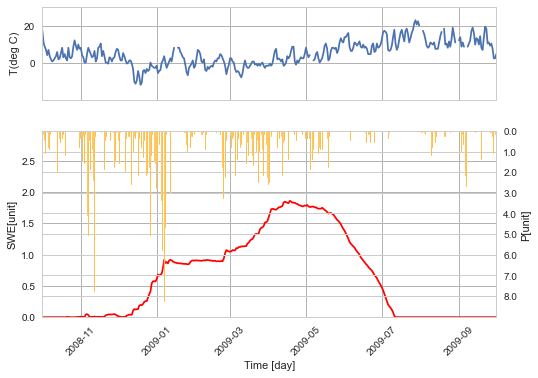

In [167]:
t = snotel_Alpine.index
sP = snotel_Alpine.daily_P_in.fillna(0)
sSWE = snotel_Alpine.SWE_m
sT = snotel_Alpine.Tmean_C

time_period = [datetime(2008, 10, 1), datetime(2009, 10, 1)] 



plotSWE_P_T(snotel_Alpine.index, 
            snotel_Alpine.daily_P_in.fillna(0), 
            snotel_Alpine.SWE_m, snotel_Alpine.Tmean_C, time_period)

/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_29596/1207554259.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


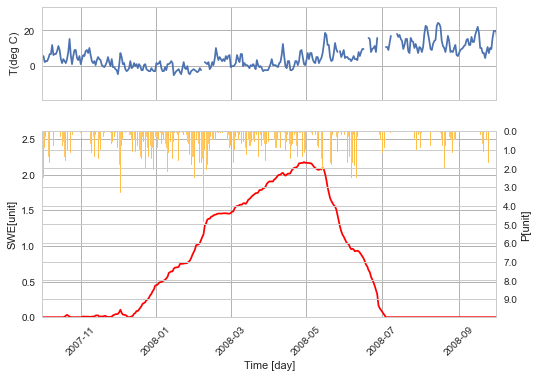

In [168]:
time_period = [datetime(2007, 10, 1), datetime(2008, 10, 1)] 

plotSWE_P_T(snotel_Skookum.index, 
            snotel_Skookum.daily_P_in.fillna(0), 
            snotel_Skookum.SWE_m, snotel_Skookum.Tmean_C, time_period)

/var/folders/cj/b1yrjqfd1kj1xd6tryxsg1_r0000gn/T/ipykernel_29596/1207554259.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


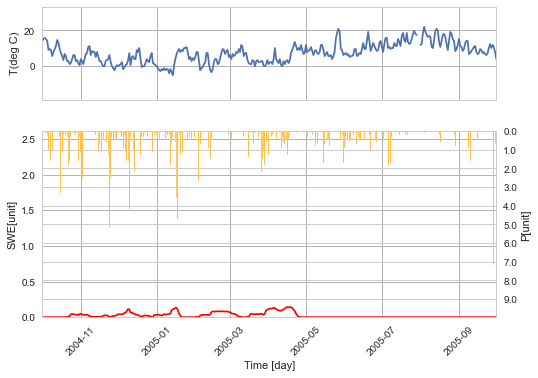

(0.0, 0.5)

In [169]:
time_period = [datetime(2004, 10, 1), datetime(2005, 10, 1)] 

plotSWE_P_T(snotel_Skookum.index, 
            snotel_Skookum.daily_P_in.fillna(0), 
            snotel_Skookum.SWE_m, snotel_Skookum.Tmean_C, time_period)
ax.set_ylim(0, 0.5)

In [170]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

# modified function from http://pyhyd.blogspot.com/2017/11/matplotlib-template-for-precipitation.html 

def plotHH(t,sP,sQ,time_period):
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
    
    # HYDROGRAM CHART
    ax = plt.subplot(gs[1])
    ax.plot(t,sQ)
    ax.set_ylabel(u'Q(m³/s)', color='b')
    ax.set_xlabel('Time (min.)')
    ax.tick_params(axis='y', colors='b')
    ax.xaxis.grid(b=True, which='major', color='.7', linestyle='-')
    ax.yaxis.grid(b=True, which='major', color='.7', linestyle='-')
    ax.set_xlim(min(t), max(t))
    ax.set_ylim(0, np.nanmax(sQ)*1.2)
    ax.set_xlim(time_period)

    # PRECIPITATION/HYETOGRAPH CHART
    ax2 = plt.subplot(gs[0])
    #ax2.bar(t, sP, 1, color='#b0c4de')
    ax2.plot(t,sP)
    ax2.xaxis.grid(b=True, which='major', color='.7', linestyle='-')
    ax2.yaxis.grid(b=True, which='major', color='0.7', linestyle='-')
    ax2.set_ylabel('P(mm)')
    ax2.set_xlim(min(t), max(t))
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    plt.tight_layout()
    ax2.invert_yaxis()
    plt.gcf().subplots_adjust(bottom=0.15)
    ax2.set_xlim(time_period)
    plt.show()
    #plt.savefig(filename,format='pdf')
    plt.close(fig)

In [171]:
#load Q data 
#
Q_df = pd.read_csv(ROOT_DIR + '/Data/Raw/dv_sf_tolt_index_12147600.txt', sep='\s+')

In [172]:
#create pandas datetime 
idx = pd.date_range("1959-12-01", periods = 22749, freq="D")
#set datetime index
Q_df = Q_df.set_index(pd.DatetimeIndex(idx))
Q_df

,datetime,Qdaily_cfs
1959-12-01,12/1/59,90.0
1959-12-02,12/2/59,110.0
1959-12-03,12/3/59,110.0
1959-12-04,12/4/59,90.0
1959-12-05,12/5/59,80.0
...,...,...
2022-03-09,3/9/22,28.2
2022-03-10,3/10/22,23.5
2022-03-11,3/11/22,21.2
2022-03-12,3/12/22,19.8


In [173]:
Q_df_  = Q_df.loc[t]
Q_df_

,datetime,Qdaily_cfs
1994-09-22,9/22/94,9.00
1994-09-23,9/23/94,8.20
1994-09-24,9/24/94,7.60
1994-09-25,9/25/94,7.10
1994-09-26,9/26/94,6.60
...,...,...
2021-09-26,9/26/21,7.49
2021-09-27,9/27/21,45.00
2021-09-28,9/28/21,136.00
2021-09-29,9/29/21,65.90


In [174]:
t

DatetimeIndex(['1994-09-22', '1994-09-23', '1994-09-24', '1994-09-25',
               '1994-09-26', '1994-09-27', '1994-09-28', '1994-09-29',
               '1994-09-30', '1994-10-01',
               ...
               '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
               '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28',
               '2021-09-29', '2021-09-30'],
              dtype='datetime64[ns]', length=9871, freq=None)

In [175]:
#function to plot T, SWE+P , Q

def plotSWE_P_T_Q(t, sP, sSWE, sT, sQ, time_period):
    fig = plt.figure()
    #gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 1])
    
    # SWE plot
    ax = plt.subplot(gs[1])
    
    ax.plot(t, sSWE, color="r")
    # Create secondary axes
    ax2 = ax.twinx()
    ax2.bar(t, -sP)

    # fix the axis labels
    #convert P to mm/day 
    
    
    max_pre = max(sP)
    
    #y2_ticks = np.linspace(0, max_pre, max_pre + 1)
    
    #y2_ticks = np.rint(y2_ticks)
    
    #y2_ticklabels = [str(i) for i in y2_ticks]
    
    #ax2.set_yticks(-1 * y2_ticks)
    #ax2.set_yticklabels(y2_ticklabels)

    ax.set_xlim(time_period) 
    
    ax.set_ylabel('SWE[m]', color='k')
    
    ax2.set_ylabel('P[mm/day]', color='k')
    
                  
    ax.tick_params(axis ='y', colors ='k')
    ax.xaxis.grid(visible = None, which='major', color='.7', linestyle='-')
    ax.yaxis.grid(visible = None, which='major', color='.7', linestyle='-')
    ax.set_xlim(min(t), max(t))
    
    ax.set_ylim(0, 0.8)
                
    #ax.set_ylim(0, np.nanmax(sSWE)*1.2)
    ax.set_xlim(time_period)
    plt.setp(ax.get_xticklabels(), visible=False)
    # temperature plot
    
    ax2 = plt.subplot(gs[0])
    
    ax2.plot(t, sT) 
    ax2.xaxis.grid(visible = None, which='major', color='.7', linestyle='-')
    ax2.yaxis.grid(visible = None, which='major', color='0.7', linestyle='-')
    ax2.set_ylabel('T(deg C)')
    ax2.set_xlim(min(t), max(t))
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.set_xlim(time_period)
    
    ax2 = plt.subplot(gs[2]) 
    
    sQ_p = sQ.loc[t]
    
    ax2.plot(t, sQ_p) 
    ax2.xaxis.grid(visible = None, which='major', color='.9', linestyle='-')
    ax2.yaxis.grid(visible = None, which='major', color='0.9', linestyle='-')
    ax2.set_ylabel('Q(cfs)')
    ax2.set_xlim(min(t), max(t))
    ax2.set_xlabel('Time')
    ax2.tick_params(axis='x', labelrotation = 45)

    plt.tight_layout()
    #ax2.invert_yaxis()
    plt.gcf().subplots_adjust(bottom = 0.15)
    ax2.set_xlim(time_period)
    #ax3.set_xlim(time_period)
    #ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
    plt.show()
    #plt.savefig(filename,format='pdf')
    plt.close(fig)

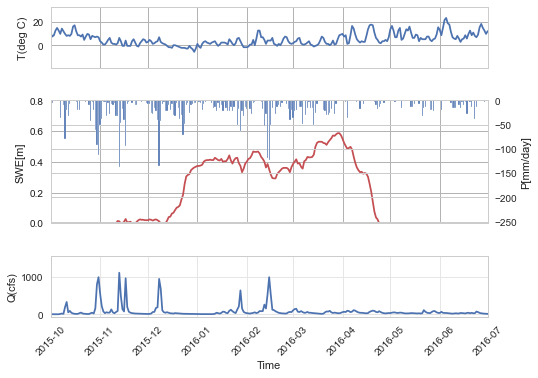

(0.0, 2.0)

In [176]:
time_period = [datetime(2015, 10, 1), datetime(2016, 7, 1)] 

plotSWE_P_T_Q(snotel_Skookum.index, 
            snotel_Skookum.daily_P_in.fillna(0)*25.4, 
            snotel_Skookum.SWE_m, snotel_Skookum.Tmean_C, Q_df.Qdaily_cfs, time_period)
ax.set_ylim(0, 2)

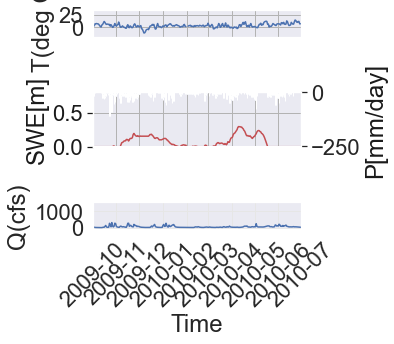

(0.0, 2.0)

In [89]:
time_period = [datetime(2009, 10, 1), datetime(2010, 7, 1)] 

plotSWE_P_T_Q(snotel_Skookum.index, 
            snotel_Skookum.daily_P_in.fillna(0)*25.4, 
            snotel_Skookum.SWE_m, snotel_Skookum.Tmean_C, Q_df.Qdaily_cfs, time_period)
ax.set_ylim(0, 2)